In [8]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5_qdess
from utils.transform import reshape_adj_channels_to_complex_vals, \
                            reshape_complex_vals_to_adj_channels

In [21]:
from include.decoder_conv import init_convdecoder
from include.fit import fit, forwardm
from utils.transform import ifft_2d, fft_2d
from include.mri_helpers import apply_mask
import copy

torch.cuda.set_device(3)

# TODO
- build empirical loss adjustment per akshay rec
    - make sure we are penalizing e1, e2 similarly
    - what is the loss for e1, e2 separately? print these in ipynb
        - if similar, then network is expressing each equally
        - if not, want to re-balance these w empirical adjustment
    - figure out what this means in terms of t2 maps...

In [10]:
file_id = '005'
ksp = load_h5_qdess(file_id)

# load, concat both echo slices
idx_kx = ksp.shape[0] // 2 # want central slice in kx (axial) b/c we undersample in (ky,kz)
ksp_echo1 = ksp[:,:,:,0,:].permute(3,0,1,2)[:, idx_kx, :, :]
ksp_echo2 = ksp[:,:,:,1,:].permute(3,0,1,2)[:, idx_kx, :, :]
ksp_orig = torch.cat((ksp_echo1, ksp_echo2), 0)

In [14]:
net, net_input, ksp_orig_ = init_convdecoder(ksp_orig)

ksp_masked, mask = apply_mask(ksp_orig_, accel=4)
im_masked = ifft_2d(ksp_masked)

In [84]:
net, l_e1, l_e2 = fit(ksp_masked=ksp_masked, img_masked=im_masked,
                       net=net, net_input=net_input, mask=mask, 
                       num_iter=1000)

### findings

- loss for e1 is higher initially
- loss for e2 doesn't really decrease until e1 is same


- loss balancing blows
- maybe just adjust energy of e2 before, then switch it back after?
    - does this mess w network init?

In [85]:
for idx in np.arange(len(l_e1)):
    if idx % 100 == 0:
        print(l_e1[idx], l_e2[idx])
#         sys.exit()

0.024138836190104485 0.01896723546087742
0.017910316586494446 0.014204863458871841
0.015521769411861897 0.011459867469966412
0.014345623552799225 0.009930400177836418
0.011941581964492798 0.008648107759654522
0.010912482626736164 0.007877340540289879
0.010115452110767365 0.007395523134618998
0.009792712517082691 0.007267666980624199
0.00874942447990179 0.006531320512294769
0.008032833226025105 0.006140128709375858


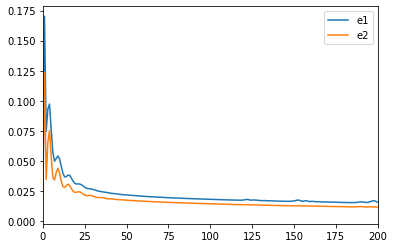

In [86]:
plt.plot(l_e1, label='e1')
plt.plot(l_e2, label='e2')
plt.xlim([0, 200])
plt.legend()
plt.show()

In [82]:
def fit(ksp_masked, img_masked, net, net_input, mask, mask2=None,
        num_iter=10000, lr=0.01, img_ls=None, dtype=torch.cuda.FloatTensor,
        LAMBDA_TV=1e-8):

    # initialize variables
    if img_ls is not None or net_input is None:
        raise NotImplementedError('incorporate original code here')
    net_input = net_input.type(dtype)
    best_net = copy.deepcopy(net)
    best_mse = 10000.0
    #mse_wrt_ksp, mse_wrt_img = np.zeros(num_iter), np.zeros(num_iter)

    p = [x for x in net.parameters()]
    optimizer = torch.optim.Adam(p, lr=lr,weight_decay=0)
    mse = torch.nn.MSELoss()

    # convert complex [nc,x,y] --> real [2*nc,x,y] to match w net output
    ksp_masked = reshape_complex_vals_to_adj_channels(ksp_masked).cuda()
    img_masked = reshape_complex_vals_to_adj_channels(img_masked)[None,:].cuda()
    mask = mask.cuda()
    if mask2 != None:
        mask2 = mask2.cuda()
        
    l_e1, l_e2 = np.empty(num_iter), np.empty(num_iter)
    
#     img_masked, k = scale_e2(img_masked)
#     img_masked = img_masked.cuda()

    for i in range(num_iter):
        def closure(): # execute this for each iteration (gradient step)

            optimizer.zero_grad()

            out = net(net_input) # out is in img space

            out_img_masked = forwardm(out, mask, mask2) # img-->ksp, mask, convert to img

            if mask2==None:# and i % 100 == 0:
                loss_e1 = mse(out_img_masked[0, :8], img_masked[0, :8]) + \
                          mse(out_img_masked[0, 16:24], img_masked[0, 16:24])
                loss_e2 = mse(out_img_masked[0, 8:16], img_masked[0, 8:16]) + \
                          mse(out_img_masked[0, 24:32], img_masked[0, 24:32])
                loss_e1, loss_e2 = loss_e1.data.cpu().numpy(), \
                                   loss_e2.data.cpu().numpy()
                l_e1[i], l_e2[i] = loss_e1, loss_e2

            loss_img = mse(out_img_masked, img_masked)
#             loss_img = balance_loss_across_e(img_masked,
#                                              out_img_masked,
#                                              mse=mse)

            loss_tv = (torch.sum(torch.abs(out_img_masked[:,:,:,:-1] - \
                                           out_img_masked[:,:,:,1:])) \
                     + torch.sum(torch.abs(out_img_masked[:,:,:-1,:] - \
                                           out_img_masked[:,:,1:,:])))
            loss_total = loss_img + LAMBDA_TV * loss_tv

            loss_total.backward(retain_graph=False)

            # mse_wrt_ksp[i] = loss_ksp.data.cpu().numpy() # store loss over each iteration

            return loss_total

        loss = optimizer.step(closure)

        # at each iteration, check if loss improves by 1%. if so, a new best net
        loss_val = loss.data
        if best_mse > 1.005*loss_val:
            best_mse = loss_val
            best_net = copy.deepcopy(net)

    return best_net, l_e1, l_e2#, mse_wrt_ksp, mse_wrt_img

# old

In [77]:
def balance_loss_across_e(img_masked, out_img_masked,
                          mse=torch.nn.MSELoss()):
    ''' given net output out_img_masked and target img_masked 
        calculate loss contributions of e1, e2 
        do empirical correction, i.e. s.t. 
            loss_total = loss_e1 + k * loss_e2, 
            where k = '''
    
    loss_e1 = mse(out_img_masked[0, :8], img_masked[0, :8]) + \
              mse(out_img_masked[0, 16:24], img_masked[0, 16:24])
    loss_e2 = mse(out_img_masked[0, 8:16], img_masked[0, 8:16]) + \
              mse(out_img_masked[0, 24:32], img_masked[0, 24:32])
    
    k = loss_e2 / loss_e1
    
    return loss_e1 + k * loss_e2

def compute_loss_tv(out_img_masked):
    ''' compute tv loss on the output img 
        do we want to do this for real + imag parts separately? '''
    return

def scale_e2(img_masked):
    ''' given adj format [re(e1) | re(e2) | im(e1) | im(e2)]
        scale e2, return constant '''
    
    out = torch.empty(img_masked.shape)
    
    e1 = torch.cat((img_masked[0,:8], img_masked[0,16:24]), dim=1)
    e2 = torch.cat((img_masked[0,8:16], img_masked[0,24:32]), dim=1)
    k = torch.mean(e1) / torch.mean(e2)
    
    out[0,:8] = img_masked[0,:8]
    out[0,8:16] = k * img_masked[0,8:16]
    out[0,16:24] = img_masked[0,16:24]
    out[0,24:32] = k * img_masked[0,24:32]
    
    return out, k